<a href="https://www.kaggle.com/code/waelrash/mnist-cnn?scriptVersionId=199870836" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,Adam
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

In [3]:
X_train = train.drop('label',axis=1)
y_train = train['label']
X_test = test.copy()

# Normalize the data

X_train = X_train / 255.0
X_test  = X_test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test  = X_test.values.reshape(-1,28,28,1)


# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)


classes = np.unique(np.argmax(y_train, axis=1)).astype(str)




In [4]:
classes

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U21')

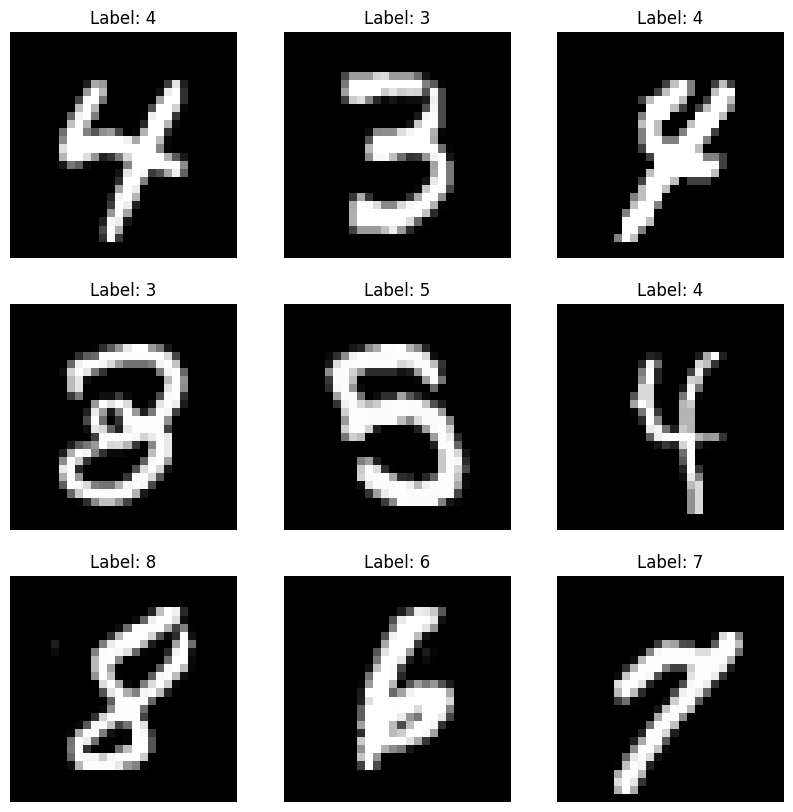

In [5]:
# plot random 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    random_index = np.random.randint(0, len(X_train))
    plt.imshow(X_train[random_index].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[random_index])}")
    plt.axis('off')
plt.show()


## Model Building

In [6]:
# Train-validation splitting
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,
                                                test_size=0.3,random_state=0)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of parameters: 34826


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

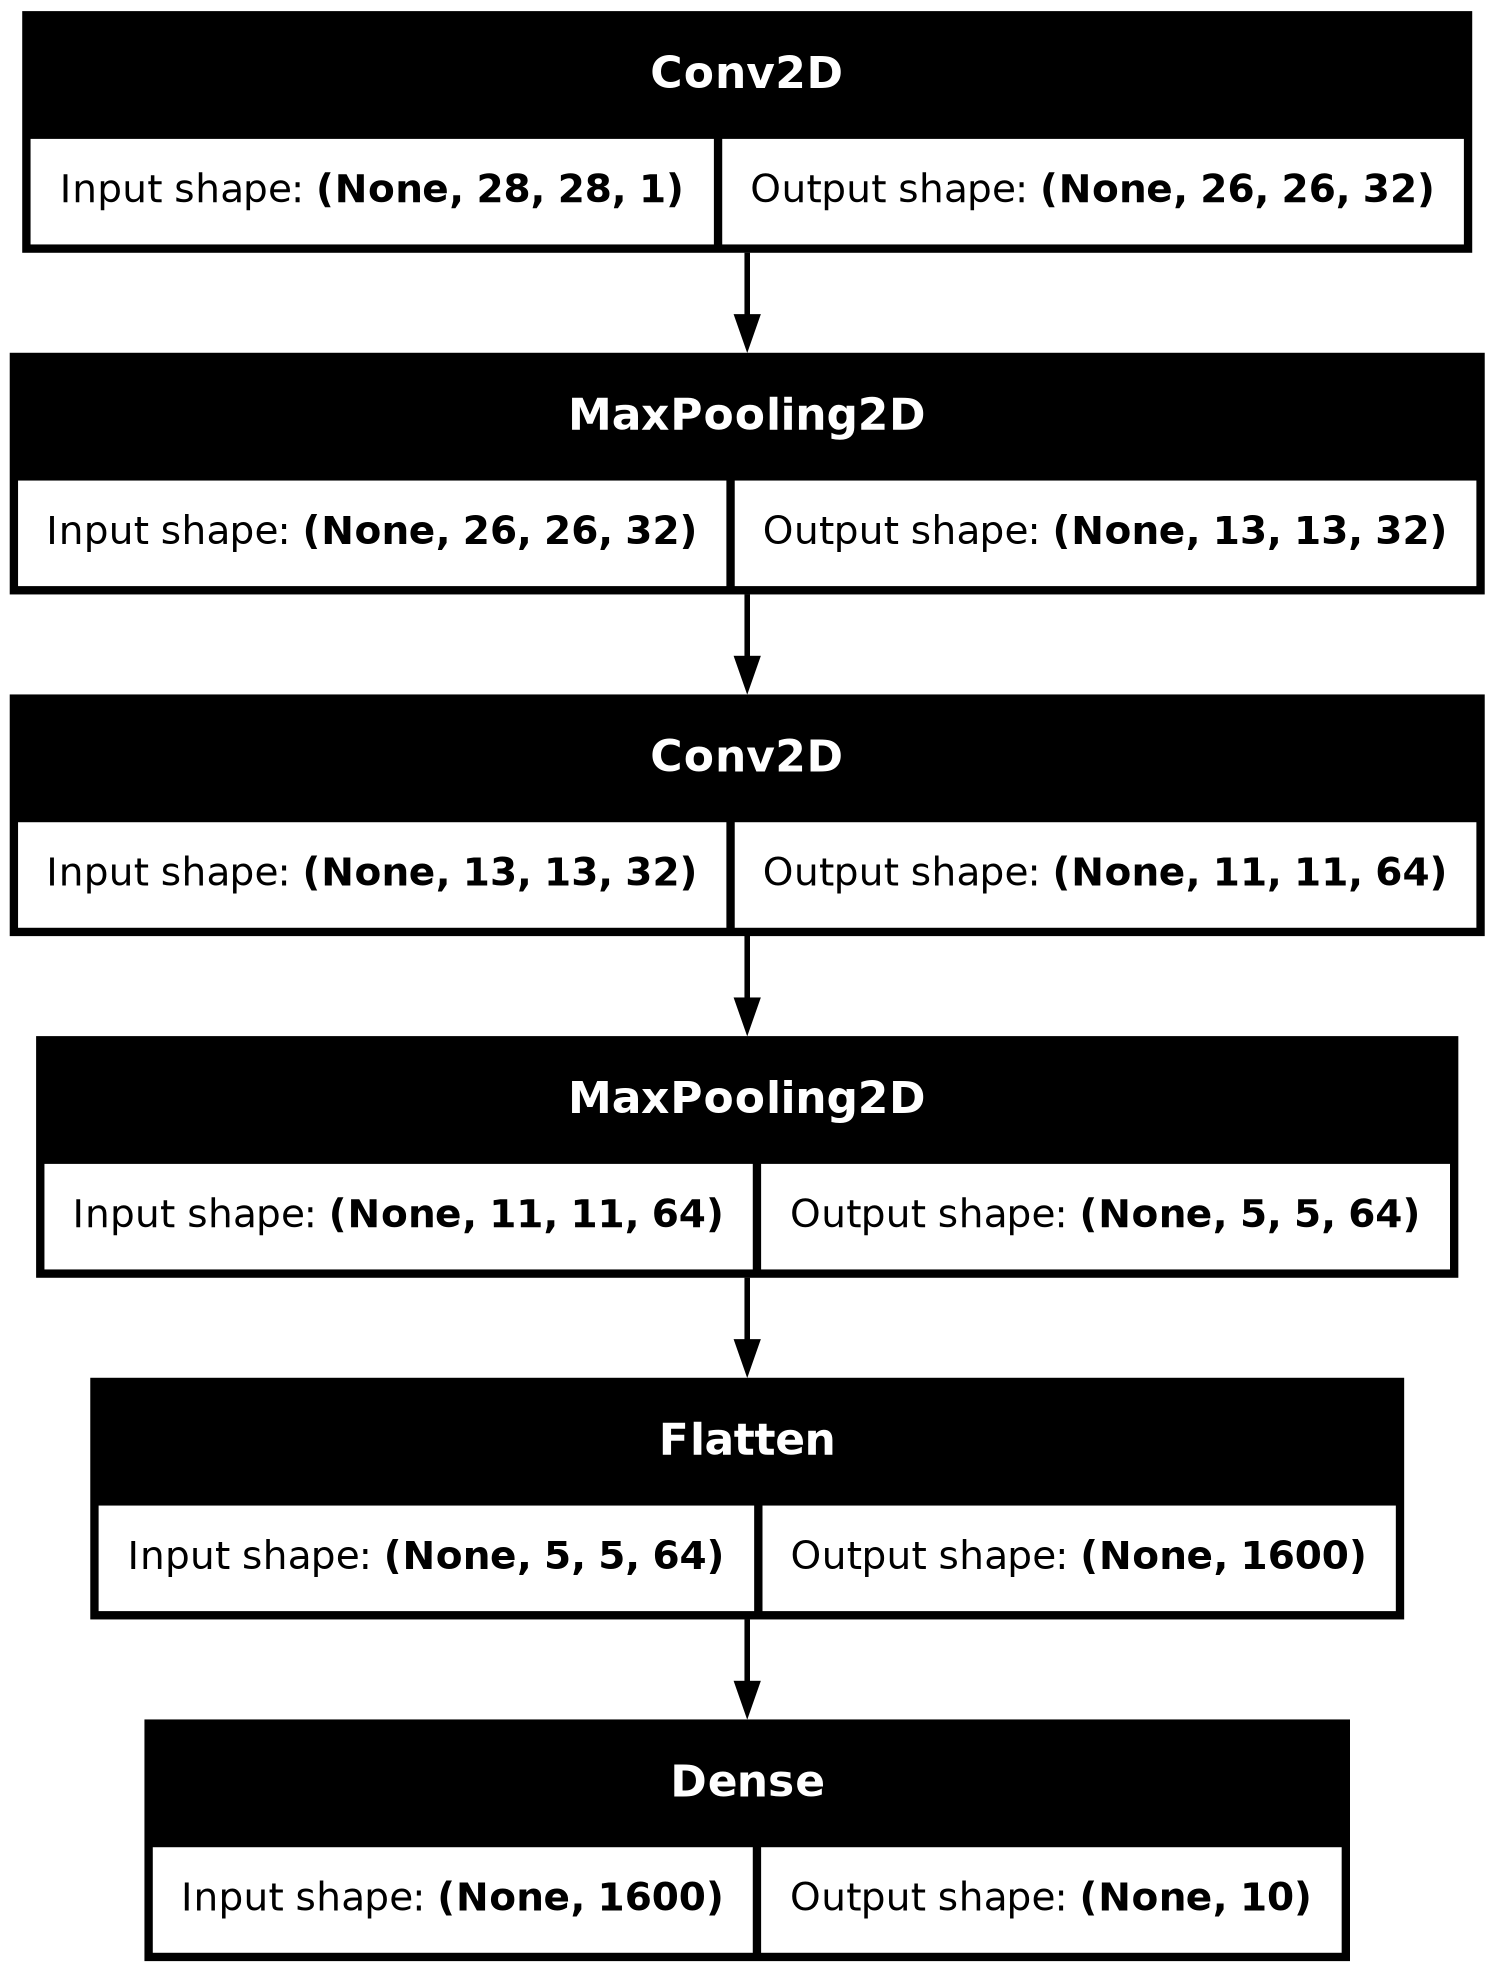

In [7]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the number of parameters
print("Number of parameters:", model.count_params())

model.summary()

# Visualize the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)







In [8]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)


In [9]:
# Defining the checkpoint callback
checkpoint_path = "results.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_freq='epoch')

Epoch 1/20


I0000 00:00:1728302239.371793      70 service.cc:145] XLA service 0x7f10b00032d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728302239.371845      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728302239.371848      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 69/919 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5261 - loss: 1.6896

I0000 00:00:1728302241.804350      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8598 - loss: 0.4915
Epoch 1: val_accuracy improved from -inf to 0.96889, saving model to results.weights.h5
919/919 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8599 - loss: 0.4912 - val_accuracy: 0.9689 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 2/20
896/919 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 0.0776
Epoch 2: val_accuracy improved from 0.96889 to 0.97825, saving model to results.weights.h5
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9755 - loss: 0.0775 - val_accuracy: 0.9783 - val_loss: 0.0688 - learning_rate: 0.0010
Epoch 3/20
894/919 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0526
Epoch 3: val_accuracy improved from 0.97825 to 0.97897, saving model to results.weights.h5
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9825 - loss: 0.0526 - val_accuracy: 0.9790 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 4/20
897/919 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accura

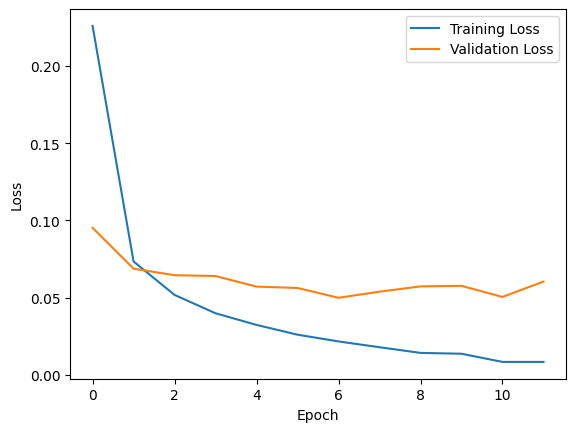

In [10]:
# Train the model
history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr,checkpoint_callback])

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [11]:
X_test = np.expand_dims(X_test,-1)

# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [12]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

In [13]:
!head submission.csv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0
